<h1 style="text-align:center;"> SIMULATION OF AN ASTRONOMICAL OBSERVATION </h1>

The goal of the code is to model the various physical and instrumental processes that transform the light from a star into a digital image, including photon flux, atmospheric effects (seeing), telescope and sensor (CCD) response, and various sources of noise.

The project is structured in several phases:

1.  Simulation of a single star, to establish the signal and noise baselines.
2.  Extension to the simulation of an entire star cluster, introducing concepts of stellar populations (IMF) and spatial structure (King profile).
3.  Analysis of the simulated data to extract the input physical parameters.
4.  Validation of the analysis methods through Monte Carlo simulations to assess accuracy and precision.
5.  Final simulation of a star cluster described by the King profile with a star-populated sky background.

In [137]:
import numpy as np
from scipy.signal import convolve2d
from scipy.integrate import quad  
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

<h1 style="text-align:center;"> Simulation of a single star </h1>

To perform the simulation, it is necessary to convert the star's magnitude into photon flux. The relationship between magnitude ($m$) and flux ($F$) is given by:
$$m_1 - m_2 = -2.5 \log_{10}\left(\frac{F_1}{F_2}\right)$$
To convert a magnitude into an absolute flux, a reference point is needed, known as the zero-point flux ($F_{ZP}$). This is the flux of a reference star with a magnitude of 0 in a given photometric band (e.g., B, V, R). The formula to calculate the flux of a star with magnitude $m$ is derived as follows:
$$
m = -2.5 \log_{10}\left(\frac{F}{F_{ZP}}\right) \implies
-0.4 \cdot m = \log_{10}\left(\frac{F}{F_{ZP}}\right)\implies
F = F_{ZP} \cdot 10^{-0.4 \cdot m}
$$
The values of $F_{ZP}$ (in units of photons per second per square meter) differ for each band as they depend on the filter's transmission curve and the standard sensor's response. In an ideal image, each source would be a single point. In reality, each point appears blurred due to contributions from neighboring points. This blurring is described by the **Point Spread Function (PSF)**. In ground-based observations, this effect is dominated by atmospheric **seeing** and can be well-approximated by a 2D Gaussian function. The width of this Gaussian is characterized by its **Full Width at Half Maximum (FWHM)**. Exists  relationship between the FWHM and the standard deviation ($\sigma$) of a Gaussian:
$$ \text{FWHM} = 2\sqrt{2\ln{2}} \cdot \sigma \approx 2.355 \cdot \sigma $$
The PSF is normalized so that the sum of all its values is 1, in order to conserve the total source flux after convolution.

The simulation generation is divided into the following steps:

1.  **Incident Signal Processing:** The raw signal undergoes several attenuations and conversions before being turned into an image:
    * **Atmospheric Extinction:** Starlight is attenuated as it passes through the atmosphere. The observed flux $F$ is $F = F_0 \cdot e^{-k' \cdot X}$ (Beer-Lambert law), where $X$ is the Airmass. In terms of magnitude, this translates to an increase in magnitude:
        $$
        \begin{aligned}
        m_{\text{observed}} &= -2.5 \cdot \log_{10}(F_0 \cdot e^{-k' \cdot X})= -2.5 \cdot \log_{10}(F_0) + (-2.5) \cdot \log_{10}(e^{-k' \cdot X}) = m_{\text{true}} + 2.5 \cdot \log_{10}(e) \cdot k' \cdot X  = m_{\text{true}} + k \cdot X \end{aligned} $$
        The term $2.5 \cdot \log_{10}(e) \cdot k'$ is grouped into a single coefficient called the extinction coefficient $k$, which depends on the wavelength (the filter band)
    * **Instrumental Characteristics:** The signal is then modulated by the sensor's **Quantum Efficiency (QE)** (the fraction of photons converted into electrons) and the overall telescope **throughput** (the optical efficiency).
    * **Collected Electrons:** The flux calculated from the extincted magnitude is multiplied by the telescope's area, throughput, QE, and exposure time to obtain the total number of electrons generated by the source.

2.  **Signal Image Creation:** An "ideal" image is created by placing all electrons into a single pixel, which is then "convolved" with the PSF. Convolution is the mathematical operation that "spreads" the signal according to the shape of the PSF.

3.  **Background Calculation:** The contribution from the **sky background** (calculated from its magnitude per square arcsecond) and the **dark current** (the sensor's thermal noise) is computed, resulting in a constant background map.

4.  **Addition of Statistical Noise:**
    * **Shot Noise:** Intrinsic noise due to the quantum nature of light, which follows a **Poisson distribution**. Its variance is equal to the signal itself ($\sigma^2 = N$). It is applied to the image containing both the star's signal and the background.
    * **Readout Noise:** Electronic noise introduced when reading the sensor's data. It is modeled as a **Gaussian** (or Normal) **distribution** with a mean of 0.

5.  **Final Image:** This is the sum of the image with shot noise and the readout noise map.

In [138]:
def calculate_source_flux(magnitude, band):
    ZP_FLUX = {'B': 1.22e10, 'V': 8.80e9, 'R': 9.70e9}
    zp_flux = ZP_FLUX[band]
    photon_flux_per_m2 = zp_flux * 10**(-0.4 * magnitude)
    return photon_flux_per_m2

def create_psf(seeing_fwhm, pixel_scale, psf_size=31):
    fwhm_in_pixels = seeing_fwhm / pixel_scale
    sigma_in_pixels = fwhm_in_pixels / 2.355
    x = np.arange(psf_size)
    y = np.arange(psf_size)
    xx, yy = np.meshgrid(x, y)
    center = psf_size // 2
    psf = np.exp(-((xx - center)**2 + (yy - center)**2) / (2 * sigma_in_pixels**2))
    return psf / np.sum(psf)

def simulate_single_source_observation(params):
    img_dims = params['image_dimensions']
    source_mag = params['source_magnitude']
    filter_band = params['filter_band']
    airmass = params['airmass']
    telescope_area = np.pi * (params['telescope_diameter'] / 2)**2
    extinction_coefficient = {'B': 0.20, 'V': 0.11, 'R': 0.04}
    extincted_magnitude = source_mag + extinction_coefficient[filter_band] * airmass
    extincted_source_flux_m2 = calculate_source_flux(extincted_magnitude, filter_band)
    source_photons_per_second = extincted_source_flux_m2 * telescope_area * params['telescope_throughput']
    source_electrons_per_second = source_photons_per_second * params['qe']
    total_source_electrons = source_electrons_per_second * params['exposure_time']
    psf = create_psf(params['seeing_fwhm'], params['pixel_scale'])
    ideal_image = np.zeros(img_dims)
    ideal_image[params['source_position']] = total_source_electrons
    signal_image = convolve2d(ideal_image, psf, mode='same')
    sky_photon_flux_m2_arcsec2 = calculate_source_flux(params['sky_brightness'], filter_band)
    pixel_area_arcsec2 = params['pixel_scale']**2
    sky_photons_per_pixel_sec = (sky_photon_flux_m2_arcsec2 * pixel_area_arcsec2 * telescope_area * params['telescope_throughput'])
    sky_electrons_per_pixel = sky_photons_per_pixel_sec * params['qe'] * params['exposure_time']
    dark_electrons_per_pixel = params['dark_current'] * params['exposure_time']
    background_map = np.full(img_dims, sky_electrons_per_pixel + dark_electrons_per_pixel)
    total_mean_image = signal_image + background_map
    image_with_shot_noise = np.random.poisson(total_mean_image)
    read_noise_map = np.random.normal(0, params['read_noise'], img_dims)
    final_image = image_with_shot_noise + read_noise_map
    return psf, final_image

In [139]:
single_star_params = {
    'telescope_diameter': 1.0,
    'telescope_throughput': 0.8,
    'seeing_fwhm': 1.5,
    'sky_brightness': 20.0,
    'airmass': 1.2,
    'pixel_scale': 0.4,
    'qe': 0.8,
    'read_noise': 20.0,
    'dark_current': 0.1,
    'image_dimensions': (200, 200),
    'exposure_time': 20.0,
    'filter_band': 'V',
    'source_magnitude': 15.0,
    'source_position': (100, 100)
}

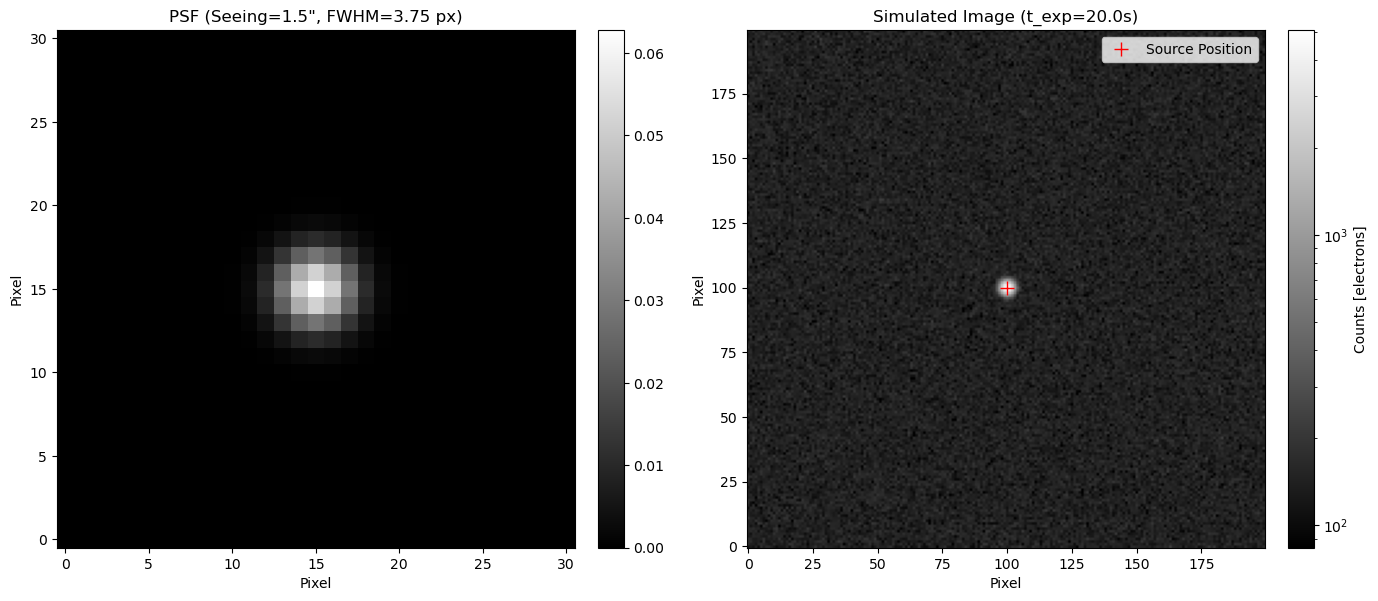

In [140]:
psf, final_image = simulate_single_source_observation(single_star_params)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax0 = axes[0]
im0 = ax0.imshow(psf, cmap='gray', origin='lower')
ax0.set_title(f"PSF (Seeing={single_star_params['seeing_fwhm']}\", FWHM={single_star_params['seeing_fwhm']/single_star_params['pixel_scale']:.2f} px)")
ax0.set_xlabel("Pixel")
ax0.set_ylabel("Pixel")
fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)

ax1 = axes[1]
vmin_calc = np.median(final_image)
vmax_calc = np.max(final_image)
vmin_safe = max(vmin_calc - 3 * single_star_params['read_noise'], 0.1)
vmax_safe = vmax_calc
im1 = ax1.imshow(final_image, cmap='gray', origin='lower', norm=LogNorm(vmin=vmin_safe, vmax=vmax_safe))
ax1.set_title(f"Simulated Image (t_exp={single_star_params['exposure_time']}s)")
ax1.set_xlabel("Pixel")
ax1.set_ylabel("Pixel")
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label="Counts [electrons]")
ax1.plot(single_star_params['source_position'][1], single_star_params['source_position'][0], 'r+', markersize=10, label='Source Position')
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()


<h1 style="text-align:center;"> Simulation of a group of stars </h1>

The IMF describes the distribution of stellar masses at their formation and is a power law:
$$\frac{dN}{dM}\propto M^{-\alpha}$$
To generate samples from this distribution, the Cumulative Distribution Function (CDF) is calculated, inverted, and then applied to uniform random numbers. 

The CDF, $P(M < M_0)$, is:
$$ P(M < M_0) = \frac{\int_{M_{min}}^{M_0} M^{-\alpha} dM}{\int_{M_{min}}^{M_{max}} M^{-\alpha} dM} = \frac{M_0^{1-\alpha} - M_{min}^{1-\alpha}}{M_{max}^{1-\alpha} - M_{min}^{1-\alpha}} $$
By setting $u = P(M < M_0)$ (where $u$ is a uniform random variable) and solving for $M_0$, we obtain the formula used in the code to generate the masses.

The next step is to convert mass to magnitude. The Mass-Luminosity Relation (MLR) is another approximate power law: $\frac{L}{L_{\odot}} \approx (\frac{M}{M_{\odot}})^\beta$, with $\beta \approx 3.5$. Combining this relation with the magnitude formula yields:
$$ m - m_{ref} = -2.5 \log_{10}\left(\frac{L}{L_{ref}}\right) = -2.5 \beta \log_{10}\left(\frac{M}{M_{ref}}\right) $$

The **Differential IMF (dN/dM)** in a log-log plot appears as a straight line with a slope of $-\alpha$.

The **Cumulative IMF (N > M)**  is the number of stars with a mass greater than M. If $\frac{dN}{dM} \propto M^{-\alpha}$, then $N(>M) \propto M^{1-\alpha}$. This method is statistically more robust because it smooths out fluctuations caused by binning. The resulting log-log plot will have a slope of $1 - \alpha$.

In a second moment we run a large number of simulations (Monte Carlo method) to find the best estimate for α. 

We will therefore collect all the measured α values and visualize their distribution using a histogram. According to the Central Limit Theorem, we expect this distribution to be a Gaussian distribution. Subsequently, we perform a Gaussian fit on the histogram. The mean and standard deviation derived from this fit will correspond to the best estimate for α and its associated error.

In [141]:
def sample_imf(n_stars, alpha, m_min, m_max):
    gamma = 1.0 - alpha
    u = np.random.uniform(0, 1, n_stars)
    m_min = m_min**gamma
    m_max = m_max**gamma
    masses = (m_min + u * (m_max - m_min))**(1.0 / gamma)
    return masses

def mass_to_magnitude(masses, beta_mlr, m_ref_1M_sun):
    magnitudes = m_ref_1M_sun - 2.5 * beta_mlr * np.log10(masses)
    return magnitudes

def simulate_cluster_observation(obs_params, imf_params, mlr_params):
    img_dims = obs_params['image_dimensions']
    telescope_area = np.pi * (obs_params['telescope_diameter'] / 2)**2
    psf = create_psf(obs_params['seeing_fwhm'], obs_params['pixel_scale'])
    extinction_coefficient = {'B': 0.20, 'V': 0.11, 'R': 0.04}
    masses = sample_imf(imf_params['n_stars'], imf_params['alpha'], imf_params['m_min'], imf_params['m_max'])
    magnitudes = mass_to_magnitude(masses, mlr_params['beta'], mlr_params['m_ref_1M_sun'])
    positions = np.random.randint(0, img_dims[0], size=(imf_params['n_stars'], 2))
    extincted_magnitudes = magnitudes + extinction_coefficient[obs_params['filter_band']] * obs_params['airmass']
    extincted_flux_m2 = calculate_source_flux(extincted_magnitudes, obs_params['filter_band'])
    source_photons_sec = extincted_flux_m2 * telescope_area * obs_params['telescope_throughput']
    source_electrons_sec = source_photons_sec * obs_params['qe']
    total_source_electrons = source_electrons_sec * obs_params['exposure_time']
    ideal_image = np.zeros(img_dims)
    pos_y = np.clip(positions[:, 0], 0, img_dims[0] - 1)
    pos_x = np.clip(positions[:, 1], 0, img_dims[1] - 1)
    np.add.at(ideal_image, (pos_y, pos_x), total_source_electrons)
    signal_image = convolve2d(ideal_image, psf, mode='same')
    sky_flux_m2_arcsec2 = calculate_source_flux(obs_params['sky_brightness'], obs_params['filter_band'])
    pixel_area_arcsec2 = obs_params['pixel_scale']**2
    sky_photons_pixel_sec = (sky_flux_m2_arcsec2 * pixel_area_arcsec2 * telescope_area * obs_params['telescope_throughput'])
    sky_electrons_pixel = sky_photons_pixel_sec * obs_params['qe'] * obs_params['exposure_time']
    dark_electrons_pixel = obs_params['dark_current'] * obs_params['exposure_time']
    background_map = np.full(img_dims, sky_electrons_pixel + dark_electrons_pixel)
    total_mean_image = signal_image + background_map
    image_with_shot_noise = np.random.poisson(total_mean_image)
    read_noise_map = np.random.normal(0, obs_params['read_noise'], img_dims)
    final_image = image_with_shot_noise + read_noise_map
    return final_image, masses, magnitudes

def power_law_model(m, A, alpha):
    return A * m**alpha

In [142]:
observation_params_cluster = {
    'telescope_diameter': 1.0,
    'telescope_throughput': 0.8,
    'seeing_fwhm': 1.5,
    'sky_brightness': 20.0,
    'airmass': 1.2,
    'pixel_scale': 0.4,
    'qe': 0.8,
    'read_noise': 50.0,
    'dark_current': 0.005,
    'image_dimensions': (512, 512),
    'exposure_time': 20.0,
    'filter_band': 'V'
}

imf_params = {
    'n_stars': 20000,
    'alpha': 2.35, 
    'm_min': 0.1,  
    'm_max': 50.0   
}

mass_luminosity_params = {
    'beta': 3.5,
    'm_ref_1M_sun': 18.0 
}

/tmp/ipykernel_78636/3055912018.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  par, pcov = curve_fit(power_law_model, x_data, y_data, p0=initial_guesses, sigma=y_error, maxfev=5000)
/tmp/ipykernel_78636/3055912018.py:35: RuntimeWarning: divide by zero encountered in divide
  chi2 = np.sum((residuals / y_error)**2)


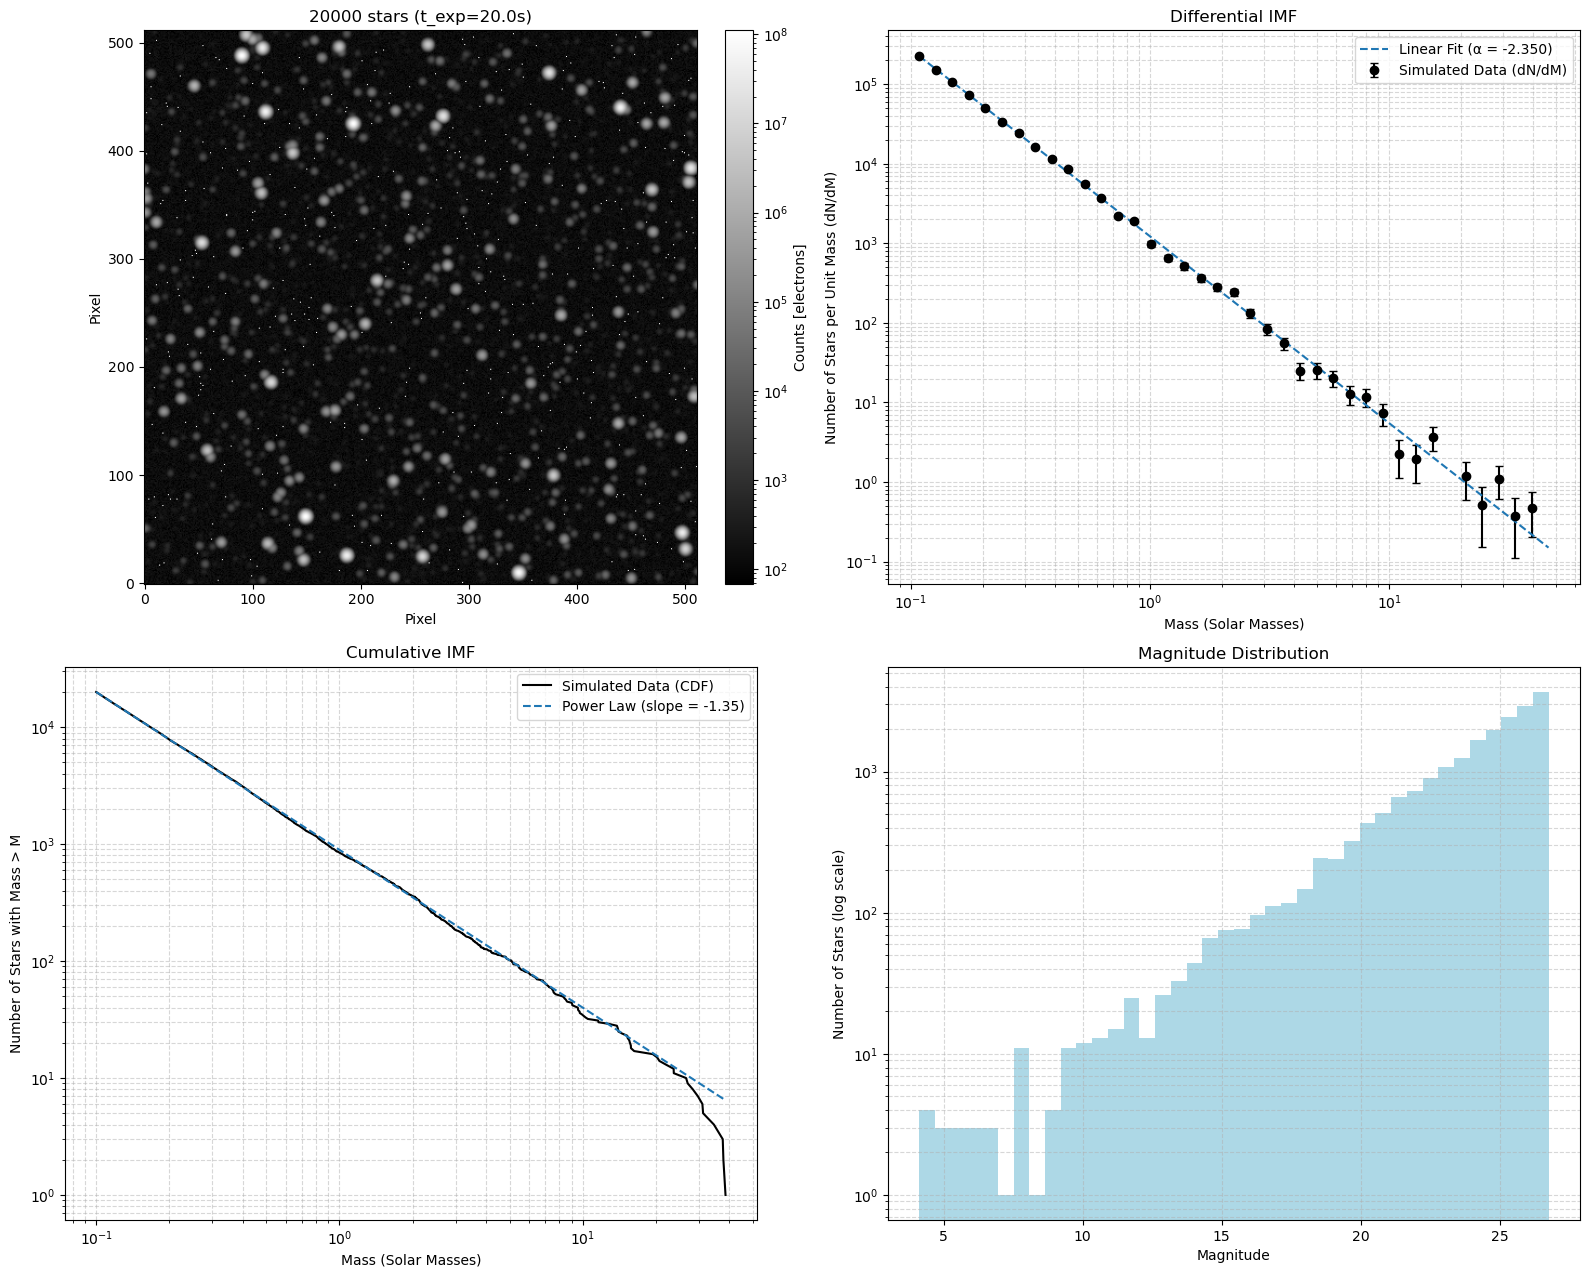

In [143]:
final_image_cluster, masses, mags = simulate_cluster_observation(observation_params_cluster, imf_params, mass_luminosity_params)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))

vmin_safe = max(np.median(final_image_cluster) - 2 * observation_params_cluster['read_noise'], 0.1)
vmax_safe = np.max(final_image_cluster)

im = ax1.imshow(final_image_cluster, cmap='gray', origin='lower', norm=LogNorm(vmin=vmin_safe, vmax=vmax_safe))
ax1.set_title(f"{imf_params['n_stars']} stars (t_exp={observation_params_cluster['exposure_time']}s)")
ax1.set_xlabel("Pixel")
ax1.set_ylabel("Pixel")
fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, label="Counts [electrons]")

num_bins_diff = 40
log_bins = np.logspace(np.log10(imf_params['m_min']), np.log10(imf_params['m_max']), num_bins_diff)
hist, bin_edges = np.histogram(masses, bins=log_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]
hist_norm = hist / bin_widths
error_poisson = np.sqrt(hist)
error_norm = error_poisson / bin_widths

ax2.errorbar(bin_centers[hist_norm > 0], hist_norm[hist_norm > 0], yerr=error_norm[hist_norm > 0], fmt='o', color='black', label='Simulated Data (dN/dM)', capsize=3)

x_data = bin_centers
y_data = hist_norm
y_error = error_norm
guess_alpha = -2.35
guess_A = y_data[0] / (x_data[0]**guess_alpha)
initial_guesses = [guess_A, guess_alpha]
par, pcov = curve_fit(power_law_model, x_data, y_data, p0=initial_guesses, sigma=y_error, maxfev=5000)
A_fit, alpha_fit = par
error_A, error_alpha = np.sqrt(np.diag(pcov))
residuals = y_data - power_law_model(x_data, A_fit, alpha_fit)
chi2 = np.sum((residuals / y_error)**2)
ndf = len(x_data) - len(par)
reduced_chi2 = chi2 / ndf if ndf > 0 else 0
fit_line = power_law_model(bin_centers, A_fit, alpha_fit)

ax2.plot(bin_centers, fit_line, '--', label='Linear Fit (α = {:.3f})'.format(alpha_fit))
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Differential IMF")
ax2.set_xlabel("Mass (Solar Masses)")
ax2.set_ylabel("Number of Stars per Unit Mass (dN/dM)")
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.5)

sorted_masses = np.sort(masses)
N_greater_M = np.arange(imf_params['n_stars'], 0, -1)
ax3.plot(sorted_masses, N_greater_M, color='black', label='Simulated Data (CDF)')
slope_cdf = -imf_params['alpha'] + 1
norm_cdf = N_greater_M[0] / (sorted_masses[0]**slope_cdf)
theory_line_cdf = norm_cdf * sorted_masses**slope_cdf

ax3.plot(sorted_masses, theory_line_cdf, '--', label=f'Power Law (slope = {slope_cdf:.2f})')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("Cumulative IMF")
ax3.set_xlabel("Mass (Solar Masses)")
ax3.set_ylabel("Number of Stars with Mass > M")
ax3.legend()
ax3.grid(True, which="both", ls="--", alpha=0.5)

ax4.hist(mags, bins=40, color='lightblue', log=True)
ax4.set_title("Magnitude Distribution")
ax4.set_xlabel("Magnitude")
ax4.set_ylabel("Number of Stars (log scale)")
ax4.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [144]:
def run_single_fit(observation_params, imf_params, mass_lum_params):
    _, masses, _ = simulate_cluster_observation(observation_params, imf_params, mass_lum_params)
    num_bins_diff = 40
    log_bins = np.logspace(np.log10(imf_params['m_min']), np.log10(imf_params['m_max']), num_bins_diff)
    hist, bin_edges = np.histogram(masses, bins=log_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    hist_norm = hist / bin_widths
    error_poisson = np.sqrt(hist)
    error_norm = error_poisson / bin_widths
    x_data = bin_centers[hist_norm > 0]
    y_data = hist_norm[hist_norm > 0]
    y_error = error_norm[hist_norm > 0]
    guess_alpha = -2.35
    guess_A = y_data[0] / (x_data[0]**guess_alpha)
    par, _ = curve_fit(power_law_model, x_data, y_data, p0=[guess_A, guess_alpha], sigma=y_error, maxfev=5000)
    return par[1]

def gaussian_model(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


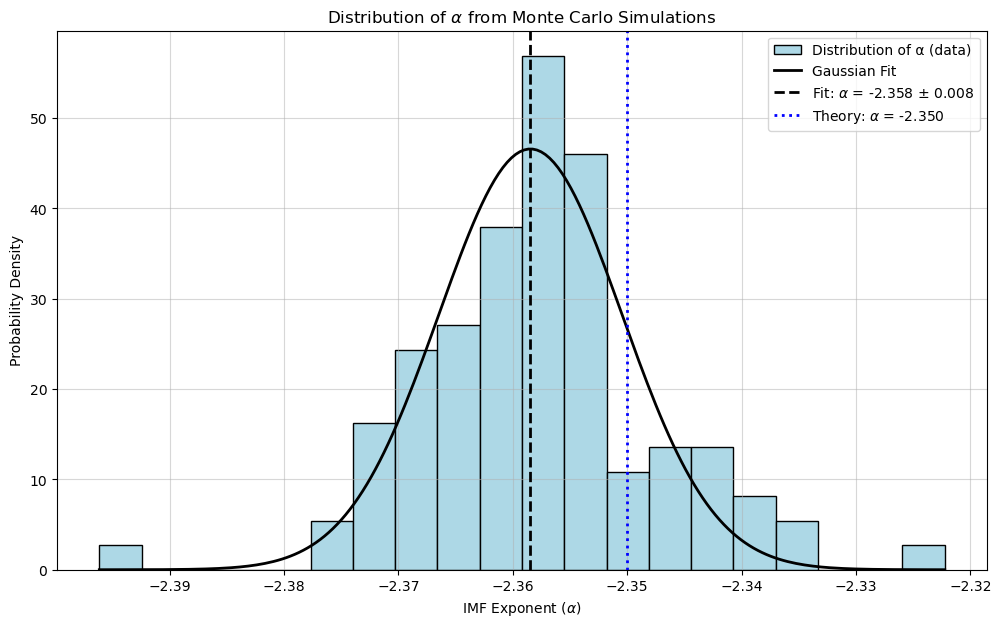

In [145]:
N_runs = 100
alpha_results = []
for i in tqdm(range(N_runs)):
    alpha_fit = run_single_fit(observation_params_cluster, imf_params, mass_luminosity_params)
    alpha_results.append(alpha_fit)

alpha_results = np.array(alpha_results)
theory_alpha = -imf_params['alpha']

counts, bin_edges = np.histogram(alpha_results, bins=20, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
guess_mean = np.mean(alpha_results)
guess_stddev = np.std(alpha_results)
guess_amplitude = np.max(counts)
initial_guesses = [guess_amplitude, guess_mean, guess_stddev]
non_zero_bins = counts > 0
par, pcov = curve_fit(gaussian_model, bin_centers[non_zero_bins], counts[non_zero_bins], p0=initial_guesses)
A_fit, mean_fit, stddev_fit = par
err_A, err_mean, err_stddev = np.sqrt(np.diag(pcov))

plt.figure(figsize=(12, 7))
plt.hist(alpha_results, bins=20, density=True, color='lightblue', edgecolor='black', label='Distribution of α (data)')
x_curve = np.linspace(bin_edges[0], bin_edges[-1], 200)
plt.plot(x_curve, gaussian_model(x_curve, A_fit, mean_fit, stddev_fit), color='black', linewidth=2, label='Gaussian Fit')
plt.axvline(mean_fit, color='black', linestyle='--', linewidth=2, label=f'Fit: $\\alpha$ = {mean_fit:.3f} $\\pm$ {abs(stddev_fit):.3f}')
plt.axvline(theory_alpha, color='blue', linestyle=':', linewidth=2, label=f'Theory: $\\alpha$ = {theory_alpha:.3f}')
plt.title(f'Distribution of $\\alpha$ from Monte Carlo Simulations')
plt.xlabel('IMF Exponent ($\\alpha$)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

<h1 style="text-align:center;"> Simulation of a star cluster according to the King profile </h1>

Real star clusters have a density that is highest at the center. The **King model** describes their surface density $\Sigma(r)$ using the core radius ($r_c$) and the tidal radius ($r_t$). The shape of the profile is often described by the **concentration parameter** $c = \log_{10}(r_t/r_c)$. The formula is:
$$
\Sigma(r) = k \left[ \frac{1}{\sqrt{1 + (r/r_c)^2}} - \frac{1}{\sqrt{1 + (r_t/r_c)^2}} \right]^2 \quad \text{for } r \le r_t
$$
To generate positions according to this profile, **rejection sampling** is used. 

As in the previous simulation, the Monte Carlo method is used to find the best estimate of the parameters $r_c$ and $r_t$.

In [146]:
def king_surface_density(r, rc, rt):
    r = np.asarray(r)
    term1 = 1 / np.sqrt(1 + (r / rc)**2)
    term2 = 1 / np.sqrt(1 + (rt / rc)**2)
    density = (term1 - term2)**2
    return np.where(r > rt, 0, density)

def generate_king_positions(n_stars, rc, rt, center):
    positions = []
    r_test_points = np.linspace(0, rt, 1000)
    pdf_test_points = r_test_points * king_surface_density(r_test_points, rc, rt)
    max_pdf_val = np.max(pdf_test_points)
    while len(positions) < n_stars:
        r_trial = np.random.uniform(0, rt)
        pdf_val_at_trial = r_trial * king_surface_density(r_trial, rc, rt)
        pdf_comparison = np.random.uniform(0, max_pdf_val)
        if pdf_comparison <= pdf_val_at_trial:
            positions.append(r_trial)
    radii = np.array(positions)
    angles = np.random.uniform(0, 2 * np.pi, n_stars)
    pos_x = center[1] + radii * np.cos(angles)
    pos_y = center[0] + radii * np.sin(angles)
    return np.column_stack((pos_y, pos_x)), radii

def simulate_king_cluster_observation(obs_params, imf_params, mlr_params, king_params):
    img_dims = obs_params['image_dimensions']
    telescope_area = np.pi * (obs_params['telescope_diameter'] / 2)**2
    psf = create_psf(obs_params['seeing_fwhm'], obs_params['pixel_scale'])
    extinction_coefficient = {'B': 0.20, 'V': 0.11, 'R': 0.04}
    masses = sample_imf(imf_params['n_stars'], imf_params['alpha'], imf_params['m_min'], imf_params['m_max'])
    magnitudes = mass_to_magnitude(masses, mlr_params['beta'], mlr_params['m_ref_1M_sun'])
    extincted_magnitudes = magnitudes + extinction_coefficient[obs_params['filter_band']] * obs_params['airmass']
    extincted_flux_m2 = calculate_source_flux(extincted_magnitudes, obs_params['filter_band'])
    source_photons_sec = extincted_flux_m2 * telescope_area * obs_params['telescope_throughput']
    source_electrons_sec = source_photons_sec * obs_params['qe']
    total_source_electrons = source_electrons_sec * obs_params['exposure_time']
    positions, radii = generate_king_positions(imf_params['n_stars'], king_params['rc'], king_params['rt'], king_params['center'])
    positions = positions.astype(int)
    ideal_image = np.zeros(img_dims)
    pos_y = np.clip(positions[:, 0], 0, img_dims[0] - 1)
    pos_x = np.clip(positions[:, 1], 0, img_dims[1] - 1)
    np.add.at(ideal_image, (pos_y, pos_x), total_source_electrons)
    signal_image = convolve2d(ideal_image, psf, mode='same')
    sky_flux_m2_arcsec2 = calculate_source_flux(obs_params['sky_brightness'], obs_params['filter_band'])
    pixel_area_arcsec2 = obs_params['pixel_scale']**2
    sky_photons_pixel_sec = (sky_flux_m2_arcsec2 * pixel_area_arcsec2 * telescope_area * obs_params['telescope_throughput'])
    sky_electrons_pixel = sky_photons_pixel_sec * obs_params['qe'] * obs_params['exposure_time']
    dark_electrons_pixel = obs_params['dark_current'] * obs_params['exposure_time']
    background_map = np.full(img_dims, sky_electrons_pixel + dark_electrons_pixel)
    total_mean_image = signal_image + background_map
    image_with_shot_noise = np.random.poisson(total_mean_image)
    read_noise_map = np.random.normal(0, obs_params['read_noise'], img_dims)
    final_image = image_with_shot_noise + read_noise_map
    return final_image, radii

def king_profile_integrand(r, rc, rt):
    shape = king_surface_density(r, rc, rt)
    return shape * 2 * np.pi * r

def king_profile_fit_func(r, k, rc, rt):
    return k * king_surface_density(r, rc, rt)

In [147]:
c_wide = 0.75
rt_pixels_wide = 250 
rc_pixels_wide = rt_pixels_wide / (10**c_wide)

king_model_params_wide = {
    'rc': rc_pixels_wide,
    'rt': rt_pixels_wide,
    'center': (observation_params_cluster['image_dimensions'][0] / 2, observation_params_cluster['image_dimensions'][1] / 2),
}

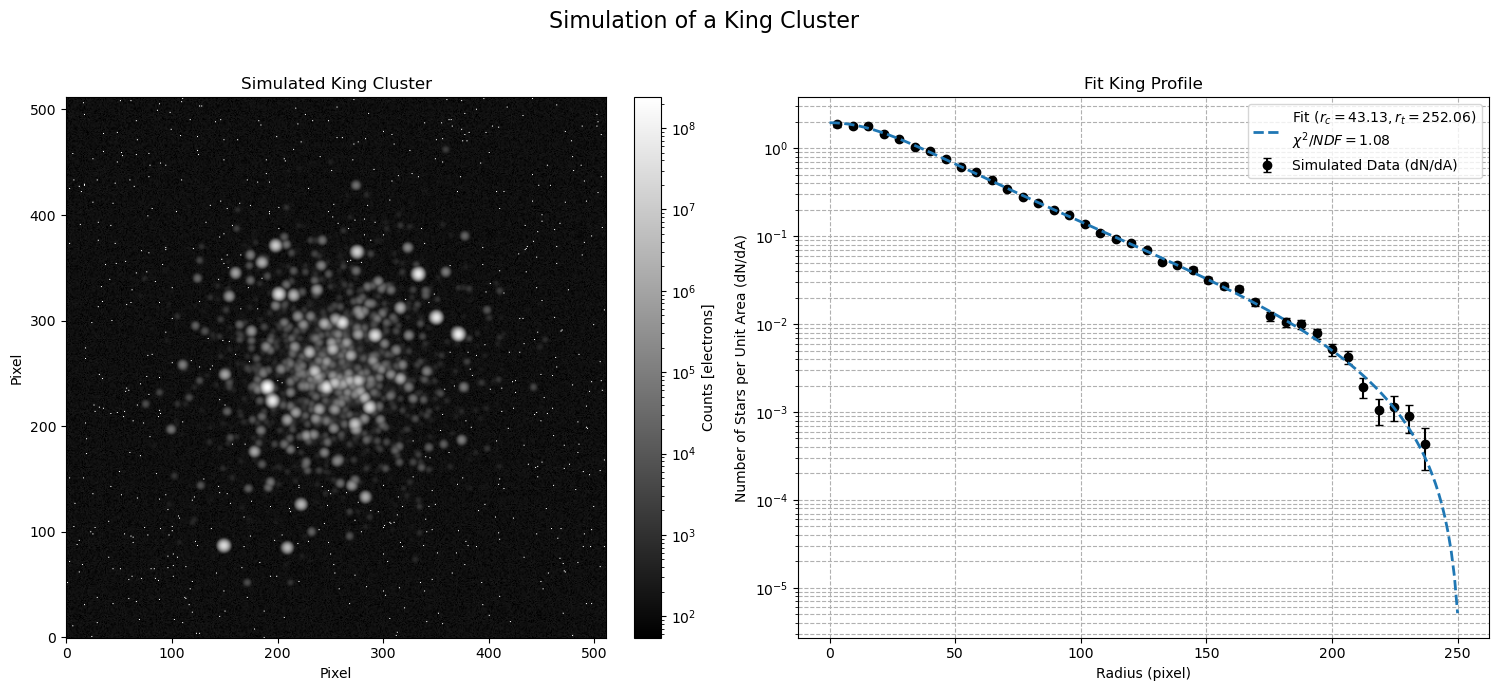

In [148]:
final_image_wide, radii_wide = simulate_king_cluster_observation(observation_params_cluster, imf_params, mass_luminosity_params, king_model_params_wide)

rc_pix = king_model_params_wide['rc']
rt_pix = king_model_params_wide['rt']
n_stars_total = imf_params['n_stars']

integral_value, _ = quad(king_profile_integrand, 0, rt_pix, args=(rc_pix, rt_pix))

k_true = n_stars_total / integral_value

num_bins_rad = 40
bins_rad = np.linspace(0, np.max(radii_wide), num_bins_rad)
hist_rad, bin_edges_rad = np.histogram(radii_wide, bins=bins_rad)
bin_centers_rad = (bin_edges_rad[:-1] + bin_edges_rad[1:]) / 2
bin_areas = np.pi * (bin_edges_rad[1:]**2 - bin_edges_rad[:-1]**2)
density_rad = np.divide(hist_rad, bin_areas, out=np.zeros_like(hist_rad, dtype=float), where=bin_areas!=0)
error_rad_poisson = np.sqrt(hist_rad)
error_density = error_rad_poisson/bin_areas
xdata = bin_centers_rad
ydata = density_rad
sigma = error_density

p0 = [1.0, rc_pixels_wide, rt_pixels_wide] 
bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
par, pcov = curve_fit(king_profile_fit_func, xdata, ydata, p0=p0, sigma=sigma, bounds=bounds, maxfev=5000)
k_fit, rc_fit, rt_fit = par
residuals = ydata - king_profile_fit_func(xdata, *par)
chi2 = np.sum((residuals / sigma)**2)
ndf = len(xdata) - len(par)
reduced_chi2 = chi2 / ndf if ndf > 0 else 0

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

vmin_safe_w = max(np.median(final_image_wide) - 2 * observation_params_cluster['read_noise'], 0.1)
vmax_safe_w = np.max(final_image_wide)

im_w = axes[0].imshow(final_image_wide, cmap='gray', origin='lower', norm=LogNorm(vmin=vmin_safe_w, vmax=vmax_safe_w))
axes[0].set_title("Simulated King Cluster")
axes[0].set_xlabel("Pixel")
axes[0].set_ylabel("Pixel")
fig.colorbar(im_w, ax=axes[0], fraction=0.046, pad=0.04, label="Counts [electrons]")

r_theory_linear = np.linspace(0, king_model_params_wide['rt'], 200)
fit_label = (f"Fit ($r_c={rc_fit:.2f}, r_t={rt_fit:.2f}$)\n"f"$\\chi^2/NDF = {reduced_chi2:.2f}$")

axes[1].errorbar(xdata, ydata, yerr=sigma, fmt='o', color='black', label='Simulated Data (dN/dA)', capsize=3, zorder=5)
axes[1].plot(r_theory_linear, king_profile_fit_func(r_theory_linear, *par), '--', label=fit_label, lw=2, zorder=10)
axes[1].set_yscale('log')
axes[1].set_title("Fit King Profile")
axes[1].set_xlabel("Radius (pixel)")
axes[1].set_ylabel("Number of Stars per Unit Area (dN/dA)")
axes[1].legend()
axes[1].grid(True, which="both", ls="--")

fig.suptitle("Simulation of a King Cluster", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [149]:
def run_single_king_fit():
    final_image_wide, radii_wide = simulate_king_cluster_observation(observation_params_cluster, imf_params, mass_luminosity_params, king_model_params_wide)
    rc_pix = king_model_params_wide['rc']
    rt_pix = king_model_params_wide['rt']
    n_stars_total = imf_params['n_stars']
    integral_value, _ = quad(king_profile_integrand, 0, rt_pix, args=(rc_pix, rt_pix))
    k_true = n_stars_total / integral_value
    num_bins_rad = 40
    bins_rad = np.linspace(0, np.max(radii_wide), num_bins_rad)
    hist_rad, bin_edges_rad = np.histogram(radii_wide, bins=bins_rad)
    bin_centers_rad = (bin_edges_rad[:-1] + bin_edges_rad[1:]) / 2
    bin_areas = np.pi * (bin_edges_rad[1:]**2 - bin_edges_rad[:-1]**2)
    density_rad = np.divide(hist_rad, bin_areas, out=np.zeros_like(hist_rad, dtype=float), where=bin_areas!=0)
    error_rad_poisson = np.sqrt(hist_rad)
    error_density = error_rad_poisson / bin_areas
    xdata = bin_centers_rad
    ydata = density_rad
    sigma = error_density
    p0 = [1.0, rc_pix, rt_pix]
    bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
    try:
        par, pcov = curve_fit(king_profile_fit_func, xdata, ydata, p0=p0, sigma=sigma, bounds=bounds, maxfev=5000)
        k_fit, rc_fit, rt_fit = par
        residuals = ydata - king_profile_fit_func(xdata, *par)
        chi2 = np.sum((residuals / sigma)**2)
        ndf = len(xdata) - len(par)
        reduced_chi2 = chi2 / ndf if ndf > 0 else np.nan
        return rc_fit, rt_fit, reduced_chi2
    except:
        return np.nan, np.nan, np.nan
    
def gaussian_model(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:34<00:00,  3.95s/it]


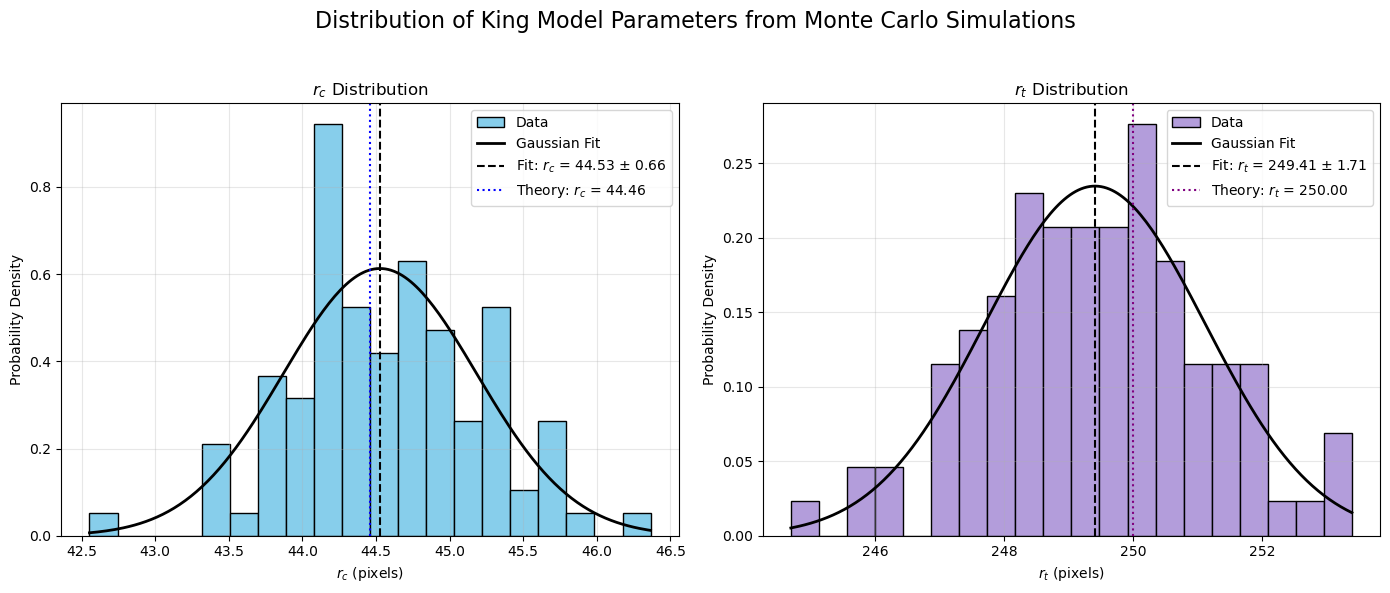

In [150]:
N_runs = 100
rc_list, rt_list, chi2_list = [], [], []
for i in tqdm(range(N_runs)):
    rc, rt, chi2_red = run_single_king_fit()
    if not np.isnan(rc):
        rc_list.append(rc)
        rt_list.append(rt)
        chi2_list.append(chi2_red)

rc_array = np.array(rc_list)
rt_array = np.array(rt_list)
rc_th = king_model_params_wide['rc']
rt_th = king_model_params_wide['rt']
counts_rc, bin_edges_rc = np.histogram(rc_array, bins=20, density=True)
bin_centers_rc = (bin_edges_rc[:-1] + bin_edges_rc[1:]) / 2
guess_mean_rc = np.mean(rc_array)
guess_std_rc = np.std(rc_array)
guess_amp_rc = np.max(counts_rc)
par_rc, pcov_rc = curve_fit(gaussian_model, bin_centers_rc, counts_rc, p0=[guess_amp_rc, guess_mean_rc, guess_std_rc])
A_rc, mu_rc, sigma_rc = par_rc
counts_rt, bin_edges_rt = np.histogram(rt_array, bins=20, density=True)
bin_centers_rt = (bin_edges_rt[:-1] + bin_edges_rt[1:]) / 2
guess_mean_rt = np.mean(rt_array)
guess_std_rt = np.std(rt_array)
guess_amp_rt = np.max(counts_rt)
par_rt, pcov_rt = curve_fit(gaussian_model, bin_centers_rt, counts_rt, p0=[guess_amp_rt, guess_mean_rt, guess_std_rt])
A_rt, mu_rt, sigma_rt = par_rt
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(rc_array, bins=bin_edges_rc, color='skyblue', edgecolor='black', density=True, label='Data')
x_rc_fit = np.linspace(bin_edges_rc[0], bin_edges_rc[-1], 200)
axs[0].plot(x_rc_fit, gaussian_model(x_rc_fit, *par_rc), color='black', lw=2, label='Gaussian Fit')
axs[0].axvline(mu_rc, color='black', linestyle='--', label=f'Fit: $r_c$ = {mu_rc:.2f} $\\pm$ {abs(sigma_rc):.2f}')
axs[0].axvline(rc_th, color='blue', linestyle=':', label=f'Theory: $r_c$ = {rc_th:.2f}')
axs[0].set_title("$r_c$ Distribution")
axs[0].set_xlabel("$r_c$ (pixels)")
axs[0].set_ylabel("Probability Density")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].hist(rt_array, bins=bin_edges_rt, color='#b39ddb', edgecolor='black', density=True, label='Data')
x_rt_fit = np.linspace(bin_edges_rt[0], bin_edges_rt[-1], 200)
axs[1].plot(x_rt_fit, gaussian_model(x_rt_fit, *par_rt), color='black', lw=2, label='Gaussian Fit')
axs[1].axvline(mu_rt, color='black', linestyle='--', label=f'Fit: $r_t$ = {mu_rt:.2f} $\\pm$ {abs(sigma_rt):.2f}')
axs[1].axvline(rt_th, color='purple', linestyle=':', label=f'Theory: $r_t$ = {rt_th:.2f}')
axs[1].set_title("$r_t$ Distribution")
axs[1].set_xlabel("$r_t$ (pixels)")
axs[1].set_ylabel("Probability Density")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.suptitle(f"Distribution of King Model Parameters from Monte Carlo Simulations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<h1 style="text-align:center;"> FInal Simulation </h1>

Real images contain the cluster superimposed on field stars. The simulation models these components separately and sums them.

The simulations are done in steps: first the ideal images are created, then they are convolved with the PSF, subsequently the background is added, and finally the noise.

In [151]:
combined_sim_params = {
    'n_stars_cluster': 10000,
    'n_stars_background': 5000    
}

n_cluster = combined_sim_params['n_stars_cluster']
cluster_masses = sample_imf(n_cluster, imf_params['alpha'], imf_params['m_min'], imf_params['m_max'])
cluster_magnitudes = mass_to_magnitude(cluster_masses, mass_luminosity_params['beta'], mass_luminosity_params['m_ref_1M_sun'])
extinction_coefficient = {'B': 0.20, 'V': 0.11, 'R': 0.04}
cluster_extincted_mags = cluster_magnitudes + extinction_coefficient[observation_params_cluster['filter_band']] * observation_params_cluster['airmass']
cluster_extincted_flux_m2 = calculate_source_flux(cluster_extincted_mags, observation_params_cluster['filter_band'])
cluster_photons_sec = cluster_extincted_flux_m2 * (np.pi * (observation_params_cluster['telescope_diameter'] / 2)**2) * observation_params_cluster['telescope_throughput']
cluster_electrons_sec = cluster_photons_sec * observation_params_cluster['qe']
cluster_total_electrons = cluster_electrons_sec * observation_params_cluster['exposure_time']
cluster_positions, _ = generate_king_positions(n_cluster, king_model_params_wide['rc'], king_model_params_wide['rt'], king_model_params_wide['center'])

n_background = combined_sim_params['n_stars_background']
background_masses = sample_imf(n_background, imf_params['alpha'], imf_params['m_min'], imf_params['m_max'])
background_magnitudes = mass_to_magnitude(background_masses, mass_luminosity_params['beta'], mass_luminosity_params['m_ref_1M_sun'])
background_extincted_mags = background_magnitudes + extinction_coefficient[observation_params_cluster['filter_band']] * observation_params_cluster['airmass']
background_extincted_flux_m2 = calculate_source_flux(background_extincted_mags, observation_params_cluster['filter_band'])
background_photons_sec = background_extincted_flux_m2 * (np.pi * (observation_params_cluster['telescope_diameter'] / 2)**2) * observation_params_cluster['telescope_throughput']
background_electrons_sec = background_photons_sec * observation_params_cluster['qe']
background_total_electrons = background_electrons_sec * observation_params_cluster['exposure_time']
background_positions = np.random.rand(n_background, 2) * observation_params_cluster['image_dimensions']

sky_flux_m2_arcsec2 = calculate_source_flux(observation_params_cluster['sky_brightness'], observation_params_cluster['filter_band'])
pixel_area_arcsec2 = observation_params_cluster['pixel_scale']**2
sky_photons_pixel_sec = (sky_flux_m2_arcsec2 * pixel_area_arcsec2 * (np.pi * (observation_params_cluster['telescope_diameter'] / 2)**2) * observation_params_cluster['telescope_throughput'])
sky_electrons_pixel = sky_photons_pixel_sec * observation_params_cluster['qe'] * observation_params_cluster['exposure_time']
dark_electrons_pixel = observation_params_cluster['dark_current'] * observation_params_cluster['exposure_time']
background_map = np.full(observation_params_cluster['image_dimensions'], sky_electrons_pixel + dark_electrons_pixel)

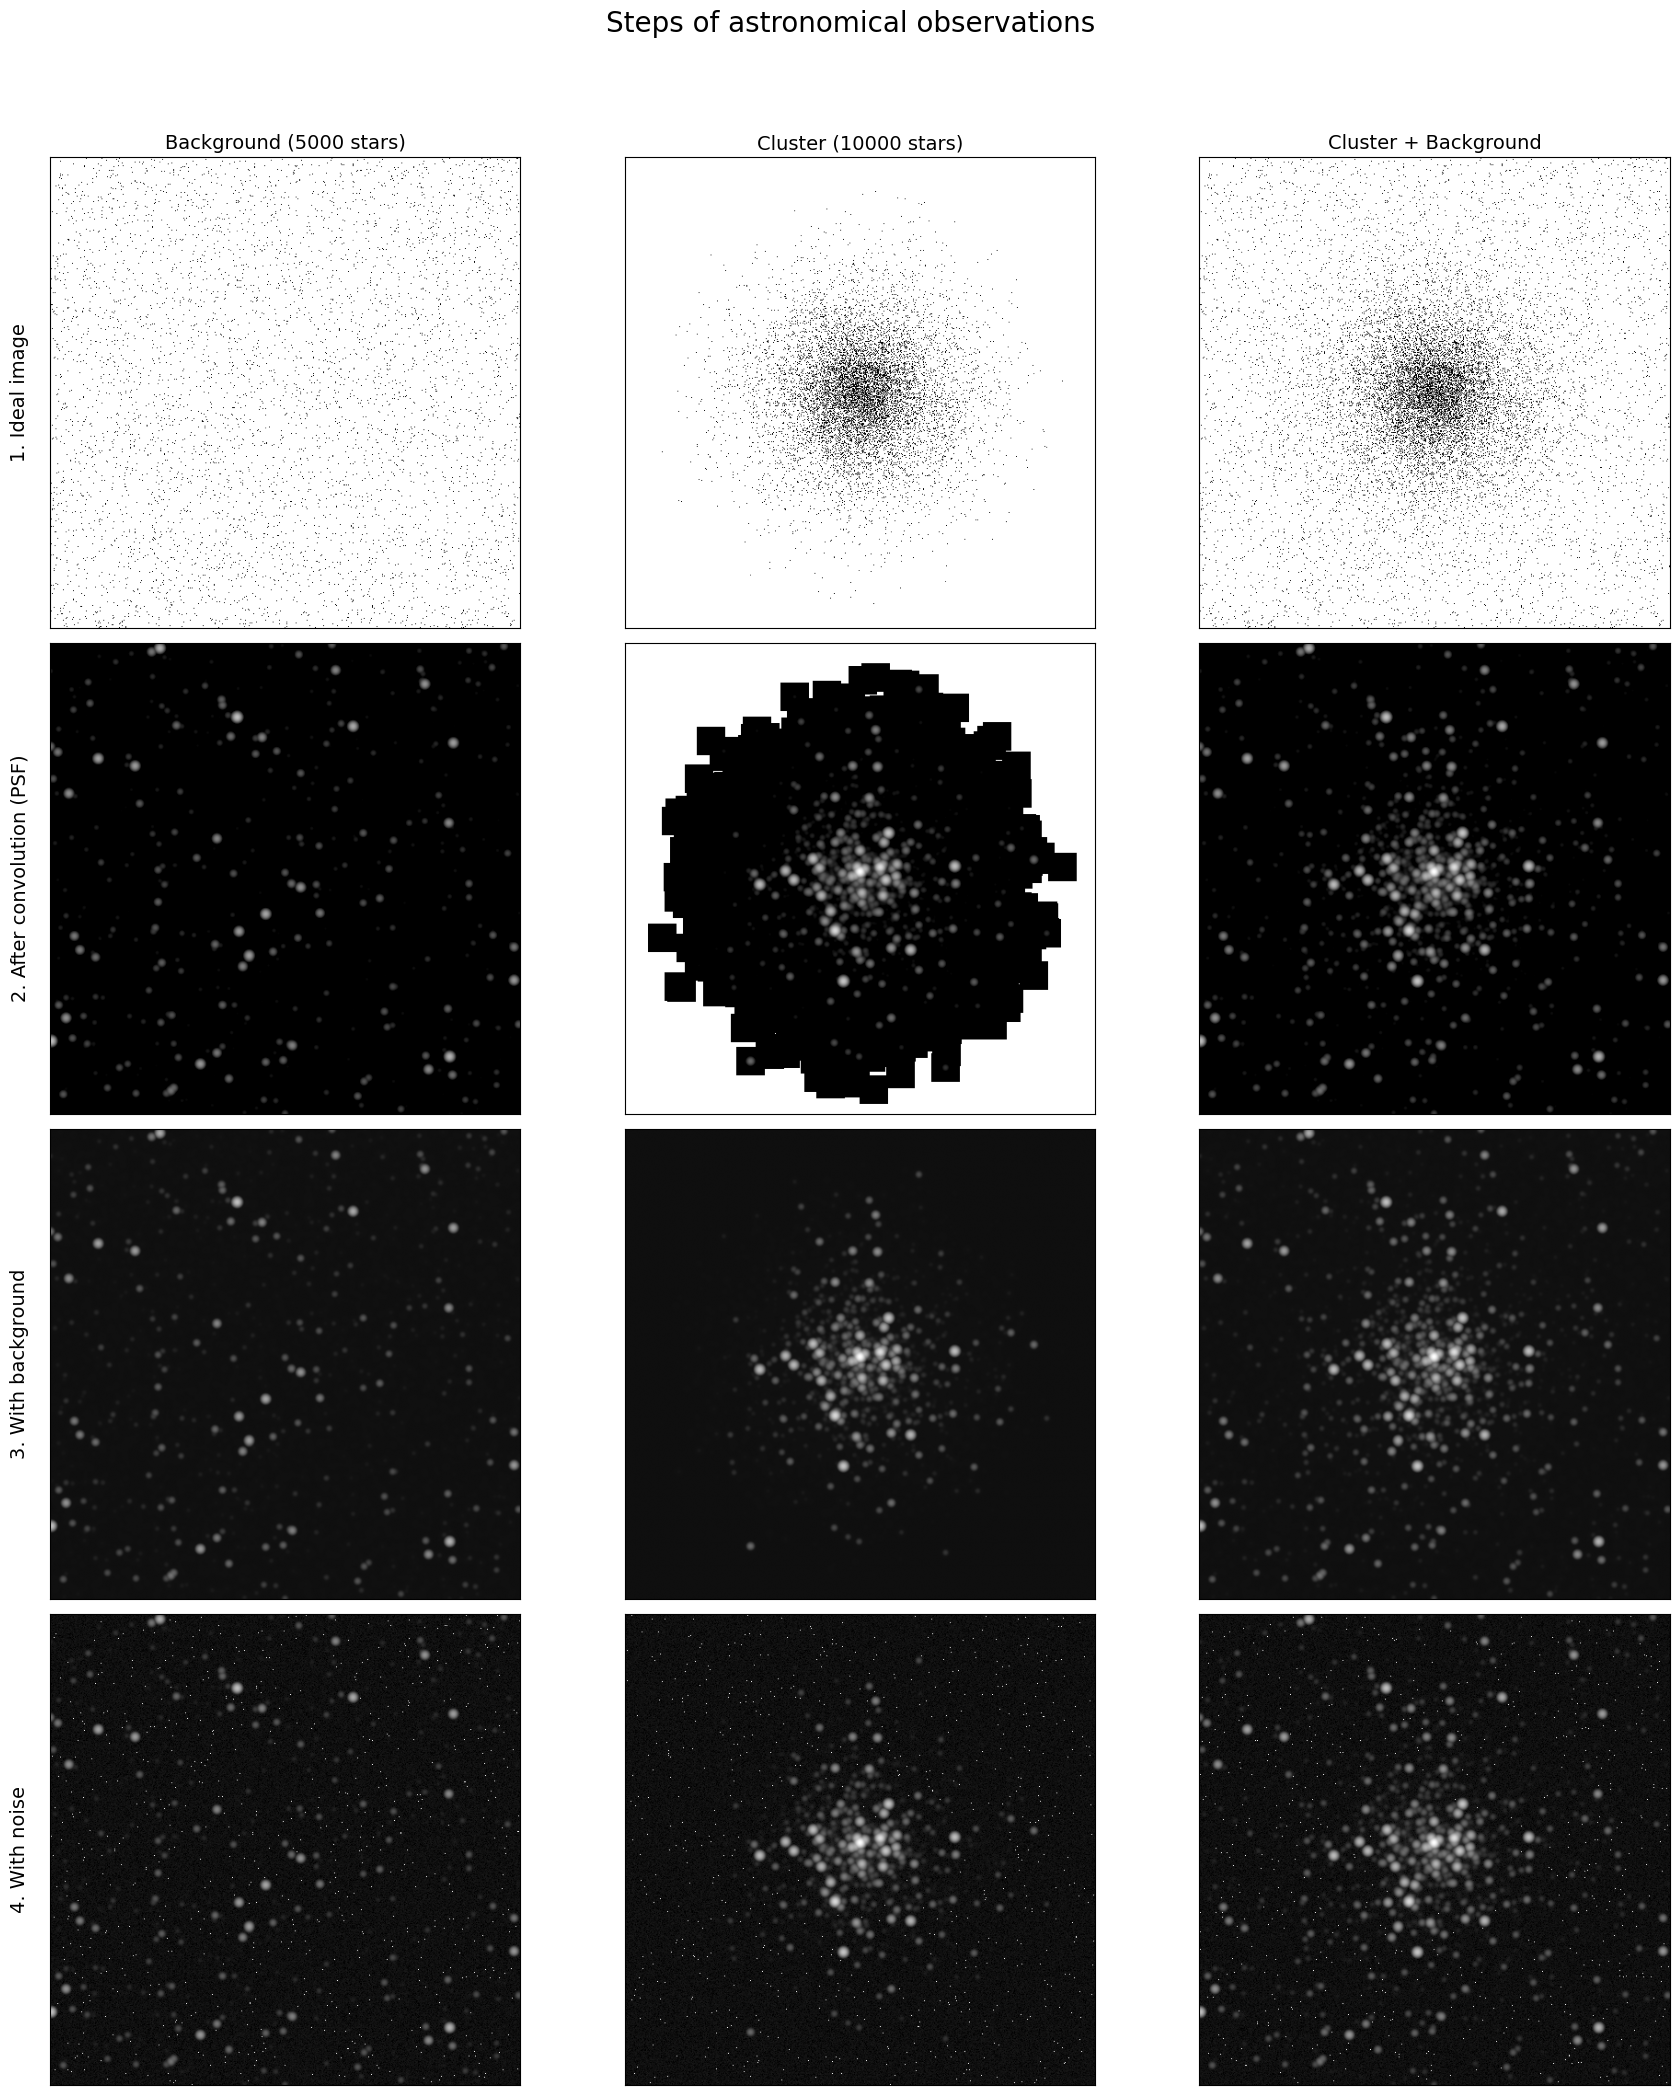

In [152]:
def create_image_steps(positions, electrons, psf, obs_params, background_map):
    ideal_image = np.zeros(obs_params['image_dimensions'])
    if positions.size > 0:
        int_positions = positions.astype(int)
        pos_y = np.clip(int_positions[:, 0], 0, obs_params['image_dimensions'][0] - 1)
        pos_x = np.clip(int_positions[:, 1], 0, obs_params['image_dimensions'][1] - 1)
        np.add.at(ideal_image, (pos_y, pos_x), electrons)
    convolved_image = convolve2d(ideal_image, psf, mode='same')
    with_background_image = convolved_image + background_map
    image_with_shot_noise = np.random.poisson(with_background_image)
    read_noise_map = np.random.normal(0, obs_params['read_noise'], obs_params['image_dimensions'])
    final_image = image_with_shot_noise + read_noise_map
    return {'ideal': ideal_image, 'convolved': convolved_image, 'with_background': with_background_image, 'final': final_image}

combined_positions = np.vstack([cluster_positions, background_positions])
combined_electrons = np.concatenate([cluster_total_electrons, background_total_electrons])

steps_background = create_image_steps(background_positions, background_total_electrons, psf, observation_params_cluster, background_map)
steps_cluster = create_image_steps(cluster_positions, cluster_total_electrons, psf, observation_params_cluster, background_map)
steps_combined = create_image_steps(combined_positions, combined_electrons, psf, observation_params_cluster, background_map)

fig, axes = plt.subplots(4, 3, figsize=(18, 22))
fig.suptitle('Steps of astronomical observations', fontsize=20)

vmin_safe_w = max(np.median(final_image_wide) - 2 * observation_params_cluster['read_noise'], 0.1)
vmax_safe_w = np.max(final_image_wide)
norm = LogNorm(vmin=vmin_safe_w, vmax=vmax_safe_w)

row_titles = ["1. Ideal image", "2. After convolution (PSF)", "3. With background", "4. With noise"]
column_titles = [f"Background ({n_background} stars)", f"Cluster ({n_cluster} stars)", "Cluster + Background"]
all_data = [steps_background, steps_cluster, steps_combined]
image_keys = ['ideal', 'convolved', 'with_background', 'final']

for i, key in enumerate(image_keys):
    for j, data_dict in enumerate(all_data):
        ax = axes[i, j]
        image_data = data_dict[key]        
        im = ax.imshow(image_data, cmap='gray', norm=norm, origin='lower')
        if j == 0:
            ax.set_ylabel(row_titles[i], fontsize=14, labelpad=15)
        if i == 0:
            ax.set_title(column_titles[j], fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()